# TRBDF-2 on the heat equation with no-flux boundary conditions in $[0,1] \times [0,1]$

In [1]:
using LinearAlgebra, Plots, Printf, LaTeXStrings

### Method of lines for 1D

We are solving the heat equation

$$ \begin{cases} u_t = \kappa u_{xx},\\
u(x,0) = \eta(x),\\
u_x(0,t) = 0,\\
u_x(1,t) = 0. \end{cases} $$

Since we are using no-flux conditions, with the method of lines, the values $U_0(t)$ and $U_{m+1}(t)$ are not directly specified by the boundary conditions.  So, we need to include them in our system of equations.  We write
\begin{align*}
U'(t) = \frac{\kappa}{h^2} A U(t) + \kappa \begin{bmatrix} \frac{U_{-1}(t)}{h^2} \\ \vdots \\ \frac{U_{m+2}(t)}{h^2} \end{bmatrix}, \quad A = \begin{bmatrix}
-2  & 1\\
1 & -2 & 1 \\
& 1 & -2 & 1\\
&& \ddots & \ddots & \ddots \\
&&& 1 & -2 \end{bmatrix}.
\end{align*}
But this then introduces "ghost values" $U_{-1}$ and $U_{m+2}$ which shouldn't be part of the system.  To approximately enforce $u_x(0,t) = 0 = u_x(1,t)$, we set
\begin{align*}
\frac{U_{1} - U_{-1}}{2h} = 0,\\
\frac{U_{m+2} - U_{m}}{2h} = 0.
\end{align*}

This then implies that we should use 
\begin{align*}
U'(t) = B U(t), \quad B = \frac{\kappa}{h^2}\begin{bmatrix}
-2  & 2\\
1 & -2 & 1 \\
& 1 & -2 & 1\\
&& \ddots & \ddots & \ddots \\
&&& 2 & -2 \end{bmatrix}.
\end{align*}

In [11]:
h = 0.1
κ = 0.3
m = convert(Int64,1/h)+1; #increase by 2 over Dirichlet conditions
k = 0.001;
T = 1;
B₀ = Tridiagonal(fill(1.0,m-1),fill(-2.0,m),fill(1.0,m-1))
B₀[1,2] = 2
B₀[end,end-1] = 2;
B = κ/(h^2)*B₀;

In [12]:
eigvals(B₀ |> Array)

11-element Vector{Float64}:
 -4.0000000000000036
 -3.9021130325903095
 -3.6180339887498976
 -3.175570504584945
 -2.6180339887498896
 -2.000000000000001
 -1.3819660112501044
 -0.8244294954150543
 -0.3819660112501052
 -0.0978869674096935
 -3.668291989104671e-16

### TRBDF-2 in one dimension

The TRBDF-2 method is a diagonally-implicit second-order accurate Runge--Kutta method.  It is given by

\begin{align*}
U^* = U^n + \frac k 4 \left( f(U^n) + f(U^*) \right),\\
U^{n+1} = \frac 1 3 \left( 4 U^* - U^n + k f(U^{n+1}) \right).
\end{align*}

As we saw on homework 3, it is L-stable and therefore a good method for diffusion.  

If $f(U) = BU$ is linear then this better written as

\begin{align*}
\left( I - \frac k 4 B \right)U^*  =  \left( I + \frac k 4 B \right) U^n,\\
\left( I - \frac k 3 B \right) U^{n+1} = \frac 1 3 \left( 4 U^* - U^n \right).
\end{align*}

And so, we first solve the first equation for $U^*$ and then solve the second equaiton for $U^{n+1}$.

In [13]:
B1 = I - (k/4)*B
B2 = I + (k/4)*B
B3 = I - (k/3)*B;
function TRBDF2_heat(U)
    Ustar = B1\(B2*U)
    return B3\((4/3)*Ustar-(1/3)*U)
end

TRBDF2_heat (generic function with 1 method)

In [14]:
η = x -> exp.(-20*(x .-1/2).^2)

#7 (generic function with 1 method)

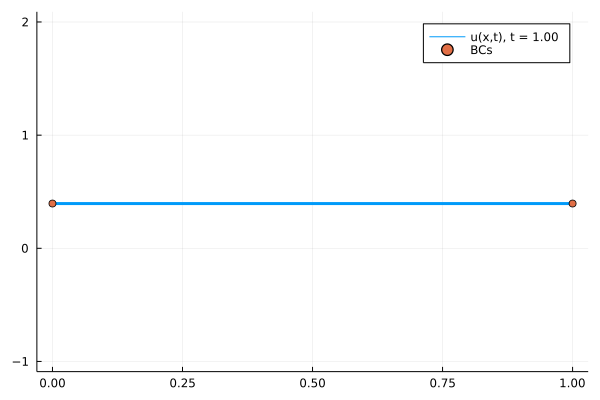

┌ Info: Saved animation to 
│   fn = /Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/heat_TRBDF2_noflux.gif
└ @ Plots /Users/thomastrogdon/.julia/packages/Plots/YAlrZ/src/animation.jl:114


Plots.AnimatedGif("/Users/thomastrogdon/Dropbox (uwamath)/Teaching/586/amath-586-2022/notebooks/heat_TRBDF2_noflux.gif")
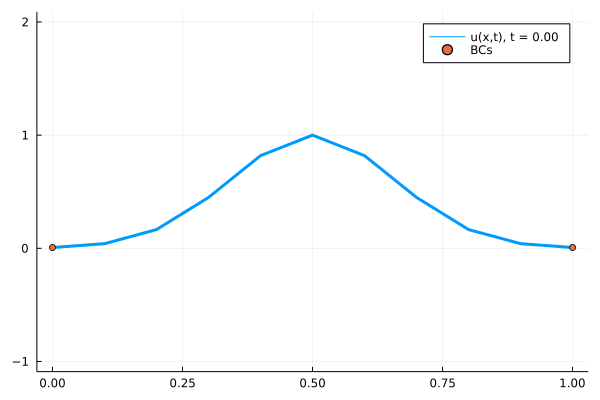

In [15]:
plot()
anim = Animation()
n = convert(Int64,ceil(T/k))
x = 0:h:1
U = η(x)
t = 0.0
plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
plot!([0,1],[U[1],U[end]], label = "BCs", seriestype = :scatter) |> IJulia.display
frame(anim)

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = TRBDF2_heat(U)
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot(x, U, xaxis = [0,1], yaxis = [-1,2],lw=3,label = @sprintf("u(x,t), t = %1.2f",t))
        plot!([0,1],[U[1],U[end]], label = "BCs", seriestype = :scatter) |> IJulia.display
        frame(anim)
    end
end
gif(anim,"heat_TRBDF2_noflux.gif")

### TRBDF-2 in two spatial dimensions

$$ \begin{cases} u_t = \kappa u_{xx} + \kappa u_{yy},\\
u(x,y,0) = \eta(x,y),\\
u_x(0,y,t) = 0,\\
u_x(1,y,t) = 0,\\
u_y(x,0,t) = 0,\\
u_y(x,1,t) = 0.\end{cases} $$

In [16]:
η = (x,y) -> exp.(-20*(x .-1/2).^2 -20*(y .-1/2).^2)

#9 (generic function with 1 method)

In [17]:
x = 0:h:1 |> Array
y = x
X = repeat(reshape(x, 1, :), length(y), 1)
Y = repeat(reverse(y), 1, length(x));

In [18]:
p = (x,y) -> (x,y)

#11 (generic function with 1 method)

In [21]:
Grid = map(p,X,Y)

11×11 Matrix{Tuple{Float64, Float64}}:
 (0.0, 1.0)  (0.1, 1.0)  (0.2, 1.0)  …  (0.8, 1.0)  (0.9, 1.0)  (1.0, 1.0)
 (0.0, 0.9)  (0.1, 0.9)  (0.2, 0.9)     (0.8, 0.9)  (0.9, 0.9)  (1.0, 0.9)
 (0.0, 0.8)  (0.1, 0.8)  (0.2, 0.8)     (0.8, 0.8)  (0.9, 0.8)  (1.0, 0.8)
 (0.0, 0.7)  (0.1, 0.7)  (0.2, 0.7)     (0.8, 0.7)  (0.9, 0.7)  (1.0, 0.7)
 (0.0, 0.6)  (0.1, 0.6)  (0.2, 0.6)     (0.8, 0.6)  (0.9, 0.6)  (1.0, 0.6)
 (0.0, 0.5)  (0.1, 0.5)  (0.2, 0.5)  …  (0.8, 0.5)  (0.9, 0.5)  (1.0, 0.5)
 (0.0, 0.4)  (0.1, 0.4)  (0.2, 0.4)     (0.8, 0.4)  (0.9, 0.4)  (1.0, 0.4)
 (0.0, 0.3)  (0.1, 0.3)  (0.2, 0.3)     (0.8, 0.3)  (0.9, 0.3)  (1.0, 0.3)
 (0.0, 0.2)  (0.1, 0.2)  (0.2, 0.2)     (0.8, 0.2)  (0.9, 0.2)  (1.0, 0.2)
 (0.0, 0.1)  (0.1, 0.1)  (0.2, 0.1)     (0.8, 0.1)  (0.9, 0.1)  (1.0, 0.1)
 (0.0, 0.0)  (0.1, 0.0)  (0.2, 0.0)  …  (0.8, 0.0)  (0.9, 0.0)  (1.0, 0.0)

In [ ]:
function plot_heat(U,x,y,t,cl,width=800)
    p1 = surface(x, y, U[end:-1:1,:], zaxis = [cl[1],cl[2]], clims= cl, aspectratio = .6, xlabel = L"x", ylabel = L"y", zlabel = L"u(x,y,t)")
    p2 = contour(x, y, U[end:-1:1,:], clims=cl, xaxis = [0,1], yaxis = [0,1], fill = true, aspectratio = 1, xlabel = L"x", ylabel = L"y")
    plot(p1, p2, layout = 2, size = (width, 7*width/10), title = @sprintf("t = %1.4f",t))
end

### Use the locally one-dimensional method (LOD)

In [ ]:
plot()
anim = Animation()
n = convert(Int64,ceil(T/k))

U = η(X,Y)
t = 0.0
plot_heat(U,x,y,t,(-0.5,1.5)) |> IJulia.display
frame(anim)

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = TRBDF2_heat(U) # diffuse in y
    U = TRBDF2_heat(U')' |> Array # diffuse in x
    # Since the matrix $B$ is the same if we reverse the order
    # of the grid points, we don't have to worry about what the
    # transpose does to the order.
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(U,x,y,t,(-0.5,1.5)) |> IJulia.display
        frame(anim)
    end
end
gif(anim,"heat_TRBDF2_noflux_2D.gif")

### TRBDF-2 in two spatial dimensions with forcing

$$ \begin{cases} u_t(x,y,t) = \kappa u_{xx}(x,y,t) + \kappa u_{yy}(x,y,t) + F(x,y),\\
u(x,y,0) = \eta(x,y),\\
u_x(0,y,t) = 0,\\
u_x(1,y,t) = 0,\\
u_y(x,0,t) = 0,\\
u_y(x,1,t) = 0.\end{cases} $$

To see how to solve this, review the TRBDF-2 scheme

\begin{align*}
U^* = U^n + \frac k 4 \left( f(U^n) + f(U^*) \right),\\
U^{n+1} = \frac 1 3 \left( 4 U^* - U^n + k f(U^{n+1}) \right).
\end{align*}

The MOL discretization in one dimension is $U'(t) = B U(t) + F_h$ where $F_h$ is a fixed vector.

So,

\begin{align*}
\left( I - \frac k 4 B \right)U^*  =  \left( I + \frac k 4 B \right) U^n + \frac k 2 F_h,\\
\left( I - \frac k 3 B \right) U^{n+1} = \frac 1 3 \left( 4 U^* - U^n \right) + \frac k 3 F_h.
\end{align*}

But when we use a splitting method, we have a choice.  Because

\begin{align*}
u_t = \kappa u_{xx} + \kappa u_{yy} + F &= \mathcal A_1(u) + \mathcal A_2(u),\\
\mathcal A_1(u) &= \kappa u_{xx} + \gamma F,\\
\mathcal A_2(u) &= \kappa u_{yy} + (1-\gamma) F.
\end{align*}

It is reasonable to use $\gamma = 1/2$ so that the forcing is treated equally at each step.  But the method we use is still just first order accurate in time regardless of how we choose $\gamma$.  We would need to use Strang splitting (11.24) to get to second order.  To see that this is the case, consider the model problem

\begin{align*}
U' = AU + BU + F.
\end{align*}
The true solution at time $t = k$ is
\begin{align*}
U(k) = e^{(A + B)k} \eta + \int_0^k e^{(A + B)(k - \tau)} F d\tau = e^{(A+B) k} \left( \eta + \int_0^k e^{-(A+B)\tau} F d\tau \right).
\end{align*}
Let's suppose that $e^{(A + B)k} \approx e^{Bk}e^{Ak}$ to a sufficiently high order.  The splitting scheme using $\mathcal N_{\mathcal A_1}$ first, followed by $\mathcal N_{\mathcal A_2}$ results in
\begin{align*}
U^* &= e^{Ak} \eta + \gamma \int_0^k e^{A(k - \tau)} F d\tau,\\
U^1 &= e^{Bk}e^{Ak} \eta + \gamma \int_0^k e^{Bk} e^{A(k - \tau)} F d\tau + (1-\gamma) \int_0^k  e^{B(k - \tau)} F d\tau\\
& = e^{Bk}e^{Ak} \left( \eta + \gamma \int_0^k e^{- A \tau} F d\tau + (1-\gamma) \int_0^k e^{- A k} e^{- B \tau} F d\tau\right).
\end{align*}

It becomes clear that we need to consider the expansion of

\begin{align*}
\mathcal E_k = \gamma \int_0^k e^{- A \tau} d\tau + (1-\gamma) \int_0^k e^{- A k} e^{- B \tau} d\tau
\end{align*}

and compare it to the expansion of
\begin{align*}
\int_0^k e^{- (A+B) \tau} d\tau
\end{align*}


Since the integral itself enforces that this quantity is $O(k)$, we keep track of the first two terms in the expansions:

\begin{align*}
\gamma \int_0^k e^{- A \tau} d\tau &= \gamma k I - \gamma \frac{k^2}{2} A + O(k^3),\\
(1-\gamma)\int_0^k e^{- A k} e^{- B \tau} d\tau &= (1-\gamma) k I - (1-\gamma)k^2A - (1-\gamma)\frac{k^2}{2} B + O(k^3),\\
\int_0^k e^{- (A+B) \tau} d\tau &= k I - (A+B) \frac{k^2}{2} + O(k^3).
\end{align*}

Summing the first two terms we find
\begin{align*}
\mathcal E_k = k I - (1- \gamma/2) k^2 A - (1-\gamma)\frac{k^2}{2} B + O(k^3)
\end{align*}
The second-order error term is:
\begin{align*}
- (1- \gamma/2) A - (1-\gamma)\frac{1}{2} B + \frac 1 2 (A + B) = \left ( \frac {\gamma-1} 2   \right) A + \left(  \gamma  - \frac 1 2\right) B
\end{align*}
If if $\gamma$ is chosen to minimize $ \left ( \frac {\gamma-1} 2   \right)^2 + \left(  \gamma  - \frac 1 2\right)^2$ one finds $\gamma = 3/5$.

Alternatively, one might want to make sure $A$ and $B$ contribute equally, so choose $\gamma  = 0$.

In [ ]:
η = (x,y) -> exp.(-20*(x .-1/2).^2 -20*(y .-1/2).^2)
F = (x,y) -> 16*sin.(4*pi*x).*sin.(4*pi*y)

In [ ]:
function TRBDF2_heat(U,F1,F2)
    Ustar = B1\(B2*U + F1)
    return B3\((4/3)*Ustar-(1/3)*U + F2)
end

In [ ]:
plot()
anim = Animation()
T = 2
n = convert(Int64,ceil(T/k))

U = η(X,Y)
Fh = F(X,Y)
F1 = (k/4)*Fh # γ = 1/2
F2 = (k/6)*Fh
t = 0.0
plot_heat(U,x,y,t,(-0.5,1.5)) |> IJulia.display
frame(anim)

fr = 100 #frames/unit time
tb = convert(Int64,ceil(n/(fr*T)))
for i = 2:n+1
    t += k
    U = TRBDF2_heat(U,F1,F2)
    U = TRBDF2_heat(U',F1',F2')' |> Array # Could use Strang splitting for second order in time
    if mod(i-1,tb) ≈ 0.0
        IJulia.clear_output(true)
        plot_heat(U,x,y,t,(-0.5,1.5)) |> IJulia.display
        frame(anim)
    end
end
gif(anim,"heat_TRBDF2_noflux_forcing_2D.gif")